In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import matplotlib.pyplot as plt
import glob
import os
import cv2
import numpy as np
import ipywidgets as widgets

from scipy.ndimage.filters import uniform_filter, median_filter
from scipy.stats import variation
from scipy.ndimage.measurements import variance
from scipy.signal import medfilt

from IPython.display import display
from skimage.filters import rank
from skimage.morphology import disk

In [2]:
def read_files():
    glob_path = os.path.join('../data', 'processed', 'train')
    paths = []
    for f in os.listdir(glob_path):
        paths.append(os.path.join(glob_path, f))
    return paths

def load_img(file, window_size, fun):
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = img.astype('float32')
    img /= 255.
    file_name = os.path.basename(file)
    filtered = fun(img, size=window_size)
    return img, filtered * 255

def parse_name(name):
    id, angle, a_class, band_name = name[:-4].split('_')
    a_class = bool(a_class)
    return id, angle, a_class, band_name

# Despeckling utils

In [5]:
COEF_VAR_DEFAULT = 0.01


def compute_coef_var(image, x_start, x_end, y_start, y_end):
    """
    Compute coefficient of variation in a window of [x_start: x_end] and
    [y_start:y_end] within the image.
    """
    assert x_start >= 0, 'ERROR: x_start must be >= 0.'
    assert y_start >= 0, 'ERROR: y_start must be >= 0.'

    x_size, y_size = image.shape
    x_overflow = x_end > x_size
    y_overflow = y_end > y_size

    assert not x_overflow, 'ERROR: invalid parameters cause x window overflow.'
    assert not y_overflow, 'ERROR: invalid parameters cause y window overflow.'

    window = image[x_start:x_end, y_start:y_end]

    coef_var = variation(window, None)

    if not coef_var:  # dirty patch
        coef_var = COEF_VAR_DEFAULT
#        print "squared_coef was equal zero but replaced by %s" % coef_var
    assert coef_var > 0, 'ERROR: coeffient of variation cannot be zero.'

    return coef_var


def calculate_all_Mi(window_flat, factor_A, window):
    """
    Compute all the weights of pixels in the window.
    """
    N, M = window.shape
    center_pixel = np.float64(window[N // 2, M // 2])
    window_flat = np.float64(window_flat)

    distances = np.abs(window_flat - center_pixel)

    weights = np.exp(-factor_A * distances)

    return weights


def calculate_local_weight_matrix(window, factor_A):
    """
    Returns an array with the weights for the pixels in the given window.
    """
    weights_array = np.zeros(window.size)
    window_flat = window.flatten()

    weights_array = calculate_all_Mi(window_flat, factor_A, window)

    return weights_array


def frost_filter(img, damping_factor=2.0, window_size=3, **kwargs):
    """
    Apply frost filter to a numpy matrix containing the image, with a window of
    win_size x win_size.
    By default, the window size is 3x3.
    """
    img = img.copy() * 255
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = window_size // 2

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset
        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N - 1
        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset
            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M - 1

            # inspired by http://www.pcigeomatics.com/cgi-bin/pcihlp/FFROST
            variation_coef = compute_coef_var(img, xleft, xright, yup, ydown)
            window = img[xleft:xright, yup:ydown]
            window_mean = window.mean()
            sigma_zero = variation_coef // window_mean  # var / u^2
            factor_A = damping_factor * sigma_zero

            weights_array = calculate_local_weight_matrix(window, factor_A)
            pixels_array = window.flatten()

            weighted_values = weights_array * pixels_array
            img_filtered[i, j] = weighted_values.sum() // weights_array.sum()

    return img_filtered

def lee_filter(img, window_size, **kwargs):
    img_mean = uniform_filter(img, (window_size, window_size))
    img_sqr_mean = uniform_filter(img**2, (window_size, window_size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance**2 / (img_variance**2 + overall_variance**2)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def mean_filter(img, disk_num, **kwargs):
    selem = disk(disk_num)
    percentile_result = rank.mean_percentile(img, selem=selem, p0=.1, p1=.9)
    return 1.-percentile_result

def median_filter_wrapper(img, median_size, **kwargs):
    img = median_filter(img, (median_size, median_size))
    return img

all_funs = [lee_filter, frost_filter, mean_filter, median_filter_wrapper]

# Usage

Id: 4b951984
Angle: 37.2802
Is Iceberg: True
Band: band2


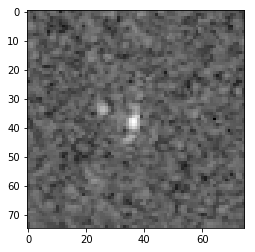

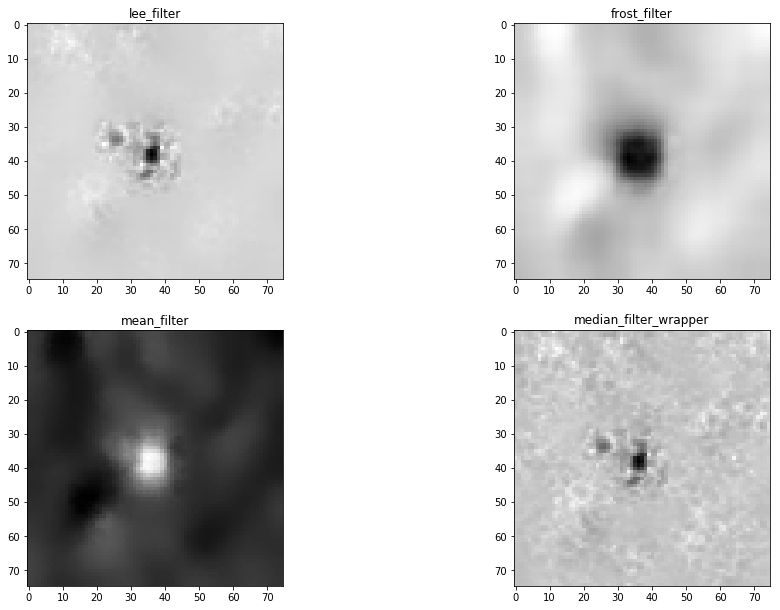

In [12]:
@widgets.interact(path=read_files(), 
                  window_size=widgets.IntSlider(min=1, max=30, step=1, continuous_update=False, value=3),
                 disk_num=widgets.IntSlider(min=1, max=100, step=1, continuous_update=False),
                 median_size=widgets.IntSlider(min=1, max=100, step=1, continuous_update=False),
                 damping_factor=widgets.FloatSlider(min=1, max=10, step=0.01, continuous_update=False))
def perform_on_image(path, **kwargs):
    plt.figure()
    width = 2
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    id, angle, a_class, band_name = parse_name(os.path.basename(path))
    print('Id: ' + id)
    print('Angle: ' + angle)
    print('Is Iceberg: ' + str(a_class))
    print('Band: ' + band_name)
    plt.imshow(img, cmap='gray')
    plt.figure(figsize=(16, 16))
    img = img.astype(np.float32)
    for i, fun in enumerate(all_funs):
        result = 255 - fun(img / 255., **kwargs) * 255
        result = lee_filter(result / 255., kwargs['window_size']) * 255
        plt.subplot(len(all_funs) // width + 1, width, i + 1)
        plt.title(fun.__name__)
        plt.imshow(result, cmap='gray')